# JL Project - Create 5 Year Forecast

In [144]:
!pip install pandas matplotlib prophet

In [145]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [147]:
pip install chardet

Note: you may need to restart the kernel to use updated packages.


In [148]:
import chardet

# Read a sample of the file to detect its encoding
with open('sales_data.csv', 'rb') as file:
    raw_data = file.read(10000)  # Read the first 10,000 bytes
    result = chardet.detect(raw_data)
    encoding = result['encoding']
    print(f"Detected encoding: {encoding}")


Detected encoding: ISO-8859-1


In [130]:
import pandas as pd

# Load the CSV with the detected encoding
df = pd.read_csv('sales_data.csv', encoding='ISO-8859-1')  # or use the detected encoding from the previous step

# Display the first few rows to verify successful loading
print(df.head())

   Quarter  Year YearQuarter      SalesOrderID    RevisionNumber  \
0        2  2011     2011-Q2  25/08/2019 00:00  08/01/1900 00:00   
1        2  2011     2011-Q2  29/08/2019 00:00  08/01/1900 00:00   
2        2  2011     2011-Q2  30/08/2019 00:00  08/01/1900 00:00   
3        2  2011     2011-Q2  05/09/2019 00:00  08/01/1900 00:00   
4        2  2011     2011-Q2  11/09/2019 00:00  08/01/1900 00:00   

          OrderDate           DueDate          ShipDate  Status  \
0  01/06/2011 00:00  13/06/2011 00:00  08/06/2011 00:00       5   
1  02/06/2011 00:00  14/06/2011 00:00  09/06/2011 00:00       5   
2  02/06/2011 00:00  14/06/2011 00:00  09/06/2011 00:00       5   
3  04/06/2011 00:00  16/06/2011 00:00  11/06/2011 00:00       5   
4  05/06/2011 00:00  17/06/2011 00:00  12/06/2011 00:00       5   

   OnlineOrderFlag  ... CreditCardApprovalCode CurrencyRateID   SubTotal  \
0             True  ...         1230194Vi41919            NaN  £3,578.27   
1             True  ...          230

In [150]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


Initial Data:
   SalesOrderID  RevisionNumber         OrderDate           DueDate  \
0         45359               8  03/01/2012 00:00  15/01/2012 00:00   
1         45389               8  07/01/2012 00:00  19/01/2012 00:00   
2         45395               8  08/01/2012 00:00  20/01/2012 00:00   
3         45407               8  10/01/2012 00:00  22/01/2012 00:00   
4         45408               8  10/01/2012 00:00  22/01/2012 00:00   

           ShipDate            Status  OnlineOrderFlag SalesOrderNumber  \
0  10/01/2012 00:00  05/01/1900 00:00             True          SO45359   
1  14/01/2012 00:00  05/01/1900 00:00             True          SO45389   
2  15/01/2012 00:00  05/01/1900 00:00             True          SO45395   
3  17/01/2012 00:00  05/01/1900 00:00             True          SO45407   
4  17/01/2012 00:00  05/01/1900 00:00             True          SO45408   

  PurchaseOrderNumber   AccountNumber  ...   TaxAmt  Freight   TotalDue  \
0                 NaN  10-4030-01

15:11:47 - cmdstanpy - INFO - Chain [1] start processing
15:11:49 - cmdstanpy - INFO - Chain [1] done processing


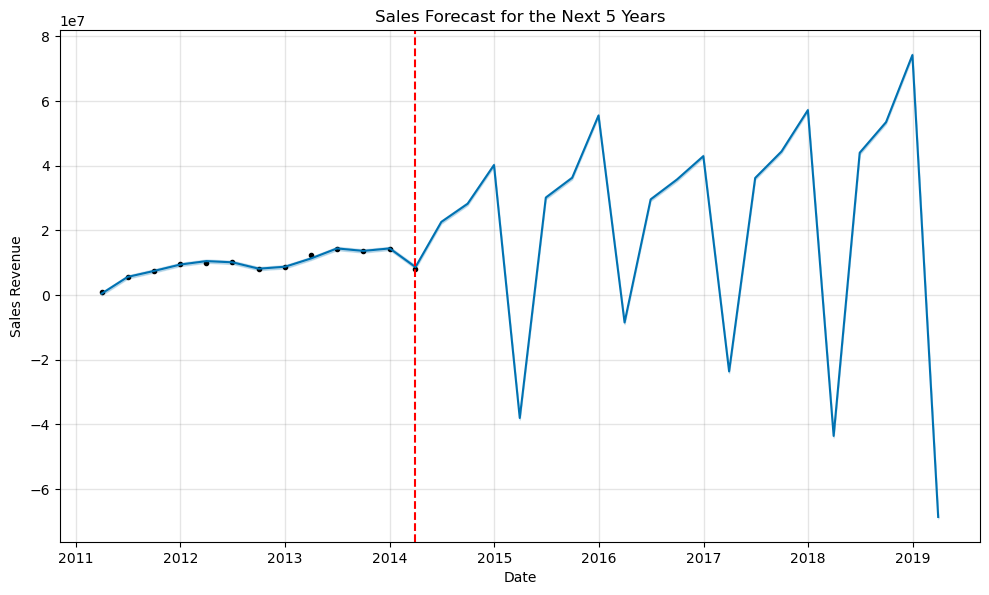


DataFrame has been exported to 'modified_sales_data.csv'.


In [153]:
# Import necessary libraries to handle data, visualize it, and perform forecasting.
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# I start by loading the sales data from a CSV file, ensuring to handle encoding issues.
df = pd.read_csv('sales_data.csv', encoding='ISO-8859-1')

# To confirm that the data has loaded correctly, I display the first few rows.
print("Initial Data:")
print(df.head())

# Next, I check the columns in the DataFrame to understand its structure better.
print("\nColumns in the DataFrame:")
print(df.columns)

# It’s important for me to remove any unnecessary whitespace from the column names for easier access.
df.columns = df.columns.str.strip()

# I ensure that the date columns (OrderDate, DueDate, ShipDate) are in the correct datetime format.
df['OrderDate'] = pd.to_datetime(df['OrderDate'], format='%d/%m/%Y %H:%M', errors='coerce')
df['DueDate'] = pd.to_datetime(df['DueDate'], format='%d/%m/%Y %H:%M', errors='coerce')
df['ShipDate'] = pd.to_datetime(df['ShipDate'], format='%d/%m/%Y %H:%M', errors='coerce')

# I check to see if the conversion to datetime format was successful by displaying the relevant columns.
print("\nConverted OrderDate, DueDate, and ShipDate columns:")
print(df[['OrderDate', 'DueDate', 'ShipDate']].head())

# If the Revenue column doesn't exist, I create it by multiplying UnitPrice and Quantity.
if 'Revenue' not in df.columns:
    if 'UnitPrice' in df.columns and 'Quantity' in df.columns:
        df['Revenue'] = df['UnitPrice'] * df['Quantity']  # Calculate Revenue
    else:
        print("Cannot calculate Revenue, 'UnitPrice' and 'Quantity' columns are required.")

# To ensure the TotalDue column is usable, I clean its values by removing currency symbols and converting to float.
df['TotalDue'] = df['TotalDue'].replace('[\£,]', '', regex=True).astype(float)

# I then add additional columns for Year and YearQuarter to facilitate time-based analysis.
df['Year'] = df['OrderDate'].dt.year
df['YearQuarter'] = df['OrderDate'].dt.to_period('Q')  # Creates Year-Quarter period

# Since Prophet requires timestamps, I convert YearQuarter to a timestamp format.
df['YearQuarter'] = df['YearQuarter'].dt.to_timestamp()  # Convert to timestamp

# To verify that my modifications to the DataFrame were successful, I check the updated columns.
print("\nUpdated DataFrame Columns:")
print(df.columns)

# Next, I aggregate the sales data by YearQuarter to prepare for forecasting.
if 'TotalDue' in df.columns:
    quarterly_sales = df.groupby(['YearQuarter']).agg({'TotalDue': 'sum'}).reset_index()

    # I rename the columns to meet Prophet's requirements for forecasting.
    quarterly_sales.rename(columns={'YearQuarter': 'ds', 'TotalDue': 'y'}, inplace=True)

    # Now, I proceed to fit a Prophet model to the aggregated quarterly sales data.
    model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)
    model.fit(quarterly_sales)

    # I create a future dataframe that represents the next 5 years (20 quarters) for my predictions.
    future = model.make_future_dataframe(periods=20, freq='QE')  # 20 quarters = 5 years

    # Using the fitted model, I forecast future sales.
    forecast = model.predict(future)

    # Finally, I visualize the forecasted sales data.
    fig = model.plot(forecast)
    plt.title('Sales Forecast for the Next 5 Years')
    plt.xlabel('Date')
    plt.ylabel('Sales Revenue')
    plt.axvline(x=pd.to_datetime(quarterly_sales['ds'].max()), color='red', linestyle='--')  # Historical cutoff line
    plt.show()
else:
    print("TotalDue column is not available; please check the input data.")

# As an optional step, I can save the modified DataFrame to a new CSV file for future reference.
output_file_path = 'modified_sales_data.csv'  
df.to_csv(output_file_path, index=False)  # Save without the index column

print(f"\nDataFrame has been exported to '{output_file_path}'.")


15:12:18 - cmdstanpy - INFO - Chain [1] start processing


Initial Data:
   SalesOrderID  RevisionNumber         OrderDate           DueDate  \
0         45359               8  03/01/2012 00:00  15/01/2012 00:00   
1         45389               8  07/01/2012 00:00  19/01/2012 00:00   
2         45395               8  08/01/2012 00:00  20/01/2012 00:00   
3         45407               8  10/01/2012 00:00  22/01/2012 00:00   
4         45408               8  10/01/2012 00:00  22/01/2012 00:00   

           ShipDate            Status  OnlineOrderFlag SalesOrderNumber  \
0  10/01/2012 00:00  05/01/1900 00:00             True          SO45359   
1  14/01/2012 00:00  05/01/1900 00:00             True          SO45389   
2  15/01/2012 00:00  05/01/1900 00:00             True          SO45395   
3  17/01/2012 00:00  05/01/1900 00:00             True          SO45407   
4  17/01/2012 00:00  05/01/1900 00:00             True          SO45408   

  PurchaseOrderNumber   AccountNumber  ...   TaxAmt  Freight   TotalDue  \
0                 NaN  10-4030-01

15:12:18 - cmdstanpy - INFO - Chain [1] done processing


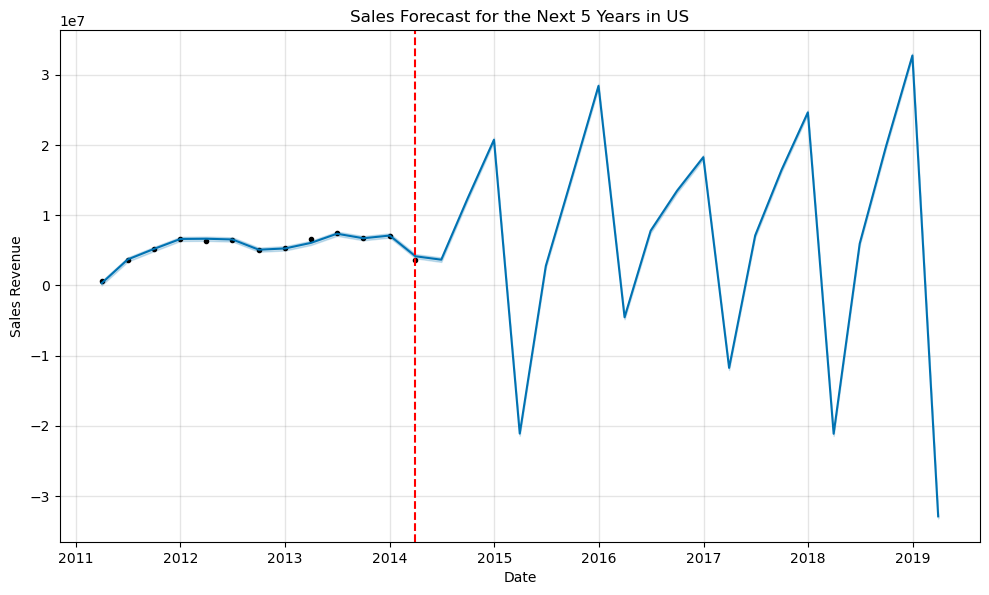

15:12:18 - cmdstanpy - INFO - Chain [1] start processing
15:12:19 - cmdstanpy - INFO - Chain [1] done processing


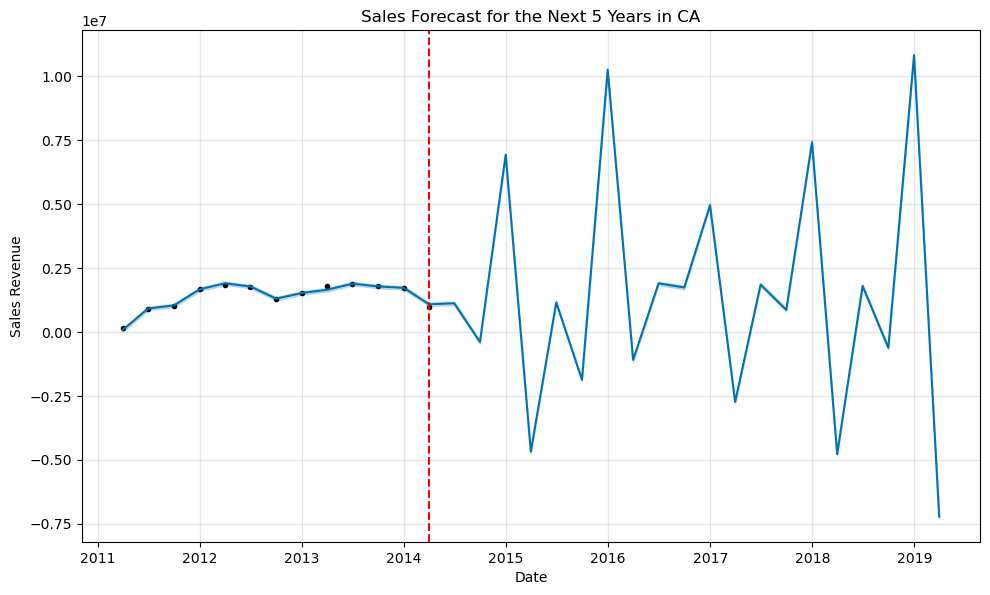

15:12:19 - cmdstanpy - INFO - Chain [1] start processing
15:12:19 - cmdstanpy - INFO - Chain [1] done processing


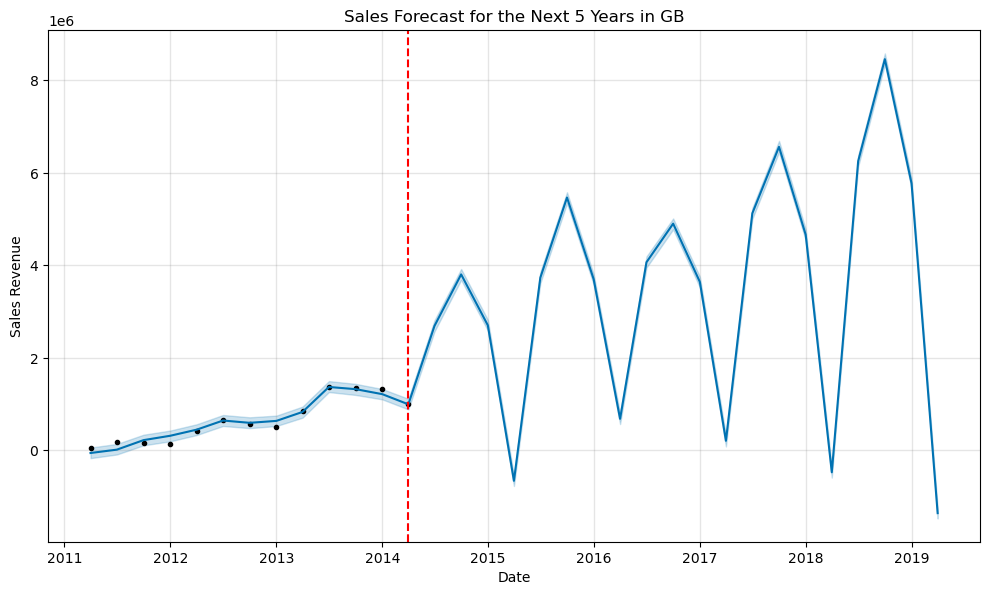

15:12:21 - cmdstanpy - INFO - Chain [1] start processing
15:12:22 - cmdstanpy - INFO - Chain [1] done processing


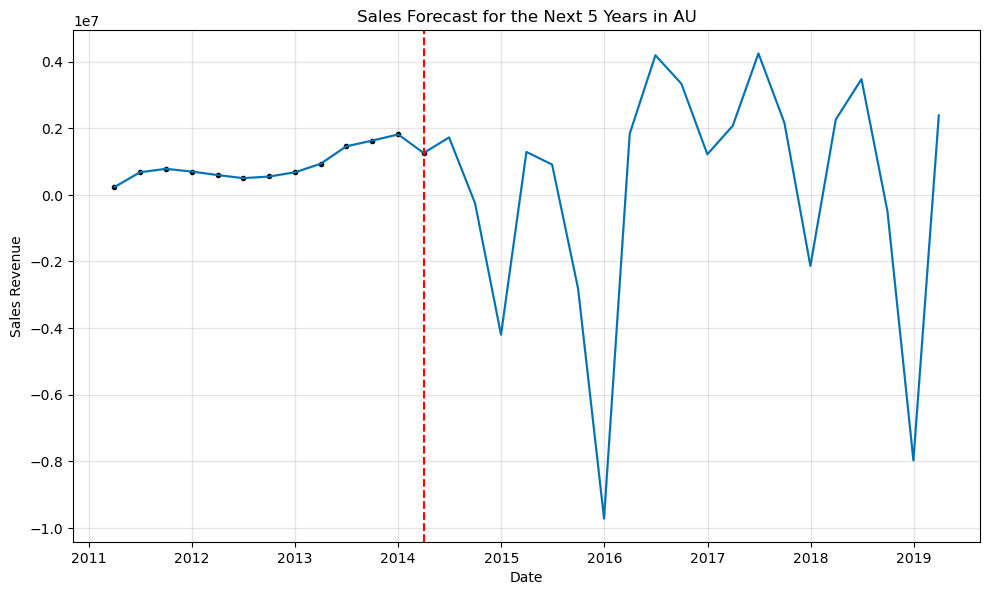

15:12:23 - cmdstanpy - INFO - Chain [1] start processing
15:12:23 - cmdstanpy - INFO - Chain [1] done processing


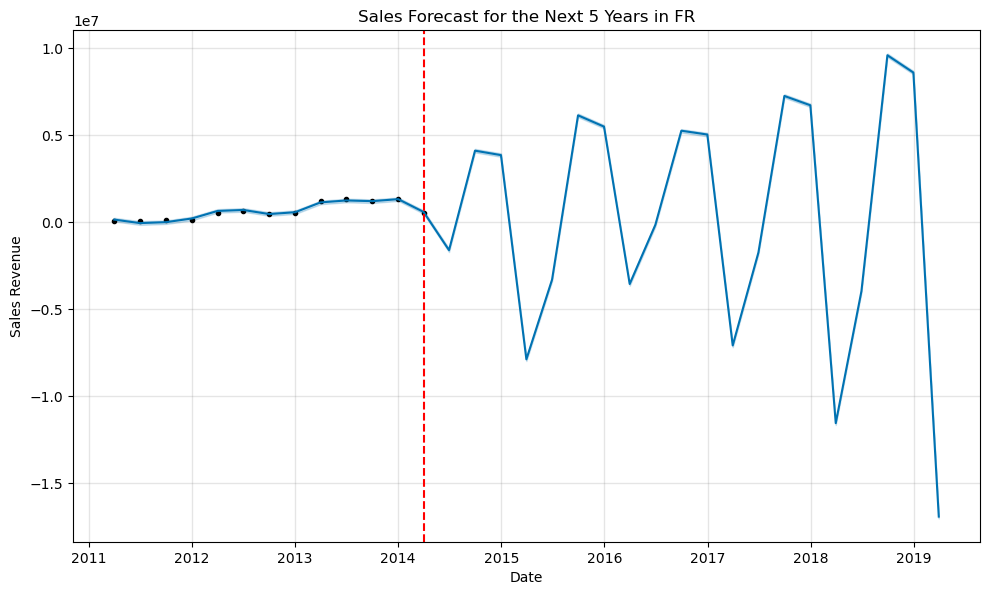

15:12:24 - cmdstanpy - INFO - Chain [1] start processing
15:12:24 - cmdstanpy - INFO - Chain [1] done processing


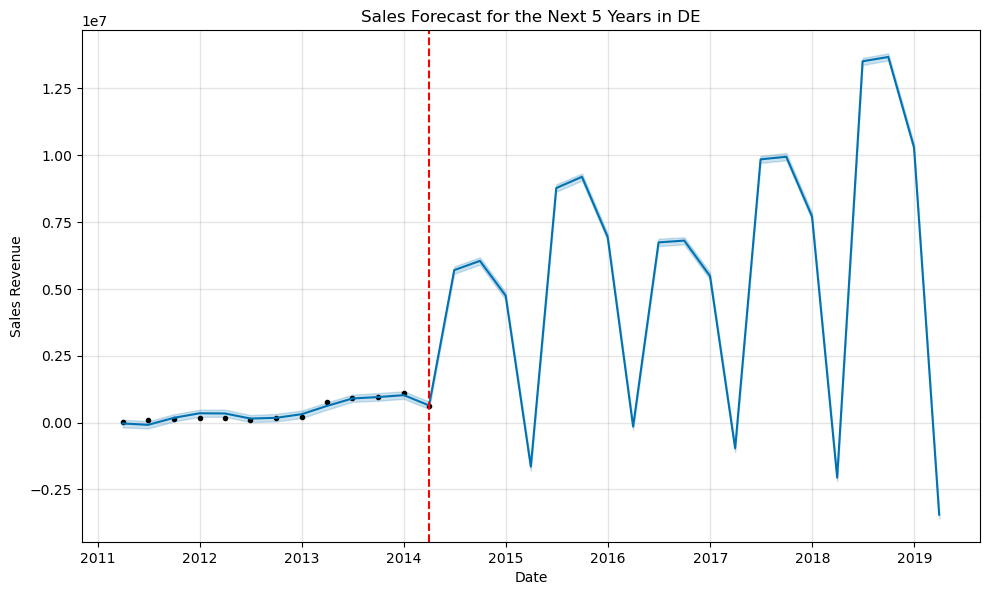


DataFrame has been exported to 'modified_sales_data.csv'.


In [156]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the sales data from the CSV file, handling encoding issues.
df = pd.read_csv('sales_data.csv', encoding='ISO-8859-1')

# Display the first few rows to verify successful loading
print("Initial Data:")
print(df.head())

# Print the columns in the DataFrame
print("\nColumns in the DataFrame:")
print(df.columns)

# Strip whitespace from the column names
df.columns = df.columns.str.strip()

# Ensure the OrderDate, DueDate, and ShipDate columns are in the correct datetime format
df['OrderDate'] = pd.to_datetime(df['OrderDate'], format='%d/%m/%Y %H:%M', errors='coerce')
df['DueDate'] = pd.to_datetime(df['DueDate'], format='%d/%m/%Y %H:%M', errors='coerce')
df['ShipDate'] = pd.to_datetime(df['ShipDate'], format='%d/%m/%Y %H:%M', errors='coerce')

# Check for any NaT values resulting from the conversion
print("\nConverted OrderDate, DueDate, and ShipDate columns:")
print(df[['OrderDate', 'DueDate', 'ShipDate']].head())

# Create a Revenue column if it doesn't exist
if 'Revenue' not in df.columns:
    if 'UnitPrice' in df.columns and 'Quantity' in df.columns:
        df['Revenue'] = df['UnitPrice'] * df['Quantity']  # Calculate Revenue
    else:
        print("Cannot calculate Revenue, 'UnitPrice' and 'Quantity' columns are required.")

# Ensure TotalDue is in the correct format
df['TotalDue'] = df['TotalDue'].replace('[\£,]', '', regex=True).astype(float)

# Add Year and YearQuarter columns for analysis
df['Year'] = df['OrderDate'].dt.year
df['YearQuarter'] = df['OrderDate'].dt.to_period('Q')  # Creates Year-Quarter period

# Convert YearQuarter to timestamp for Prophet
df['YearQuarter'] = df['YearQuarter'].dt.to_timestamp()  # Convert to timestamp

# Verify that the TotalDue column is created
print("\nUpdated DataFrame Columns:")
print(df.columns)

# Now, I'll group the sales data by SalesTerritory.CountryRegionCode and YearQuarter for forecasting
if 'TotalDue' in df.columns and 'Sales.SalesTerritory.CountryRegionCode' in df.columns:
    # Get the unique regions to loop through
    regions = df['Sales.SalesTerritory.CountryRegionCode'].unique()
    
    for region in regions:
        # Filter data for the current region
        region_data = df[df['Sales.SalesTerritory.CountryRegionCode'] == region]

        # Aggregate sales data by YearQuarter for the current region
        quarterly_sales = region_data.groupby(['YearQuarter']).agg({'TotalDue': 'sum'}).reset_index()

        # Rename columns for Prophet
        quarterly_sales.rename(columns={'YearQuarter': 'ds', 'TotalDue': 'y'}, inplace=True)

        # Fit a Prophet model to the region's quarterly sales data
        model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)
        model.fit(quarterly_sales)

        # Create a future dataframe that represents the next 5 years (20 quarters)
        future = model.make_future_dataframe(periods=20, freq='QE')  # Change frequency to 'QE'

        # Forecast the future sales
        forecast = model.predict(future)

        # Plot the forecast for the current region
        fig = model.plot(forecast)
        plt.title(f'Sales Forecast for the Next 5 Years in {region}')
        plt.xlabel('Date')
        plt.ylabel('Sales Revenue')
        plt.axvline(x=pd.to_datetime(quarterly_sales['ds'].max()), color='red', linestyle='--')  # Historical cutoff line
        plt.show()
else:
    print("TotalDue or Region column is not available; please check the input data.")

# Optionally, save the modified DataFrame to a new CSV file for future reference
output_file_path = 'modified_sales_data.csv'  
df.to_csv(output_file_path, index=False)  # Save without the index column

print(f"\nDataFrame has been exported to '{output_file_path}'.")
